In [13]:
import torch as T
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import copy
import gym
from gym.wrappers import RescaleAction
import random
from torch.utils.tensorboard import SummaryWriter
from icsl_rl.network import QNetwork

from icsl_rl.utils import _read_yaml

from icsl_rl.replaybuffer import PrioritizedReplayBuffer


In [14]:
parameter_patgh = './icsl_rl/Hyperparameter/dqn.yaml'   # Algorithms can be chosen by themselves
config = _read_yaml(parameter_patgh)
print(config)

{'algorithm': 'DQN', 'critic_lr': 0.001, 'gamma': 0.99, 'tau': 0.01, 'hidden_size': 128, 'update_rate': 100, 'buffer_size': 1000, 'batch_size': 32, 'epsilon': 1.0, 'min_epsilon': 0.1, 'epsilon_decay': 0.0005, 'use_epsilon': True, 'is_discrete': True, 'use_noisy_layer': False, 'is_off_policy': True}


In [15]:
import argparse
device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
# In the jupyter book, the argparse library is not easy to use, so use the following form instead
args = argparse.Namespace(algorithm='DQN', device=device, evaluate=False)
args.__dict__ = config
args.device = device                # GPU or CPU
args.seed = 123                     # random seed setting
args.render = False                 # Visualization during training.
args.time_steps = 20000           # total training step
args.episode = 1000000              # total episode
args.save_dir = "./model"           # Where to store the trained model
args.save_rate = 2000               # store rate
args.model_dir = ""                 # Where to store the trained model
args.evaluate_episodes = 10         # Parameters for Model Prediction
args.evaluate = False                # Parameters for Model Prediction
args.evaluate_rate = 1000           # Parameters for Model Prediction
args.is_store_transition = False    # Store expert data
args.env_name = 'CartPole-v0'          # discrete env
args.alpha = 0.2
args.beta = 0.6
args.prior_eps = 0.000001    # 1e-6
print(args)

Namespace(algorithm='DQN', alpha=0.2, batch_size=32, beta=0.6, buffer_size=1000, critic_lr=0.001, device=device(type='cuda', index=0), env_name='CartPole-v0', episode=1000000, epsilon=1.0, epsilon_decay=0.0005, evaluate=False, evaluate_episodes=10, evaluate_rate=1000, gamma=0.99, hidden_size=128, is_discrete=True, is_off_policy=True, is_store_transition=False, min_epsilon=0.1, model_dir='', prior_eps=1e-06, render=False, save_dir='./model', save_rate=2000, seed=123, tau=0.01, time_steps=20000, update_rate=100, use_epsilon=True, use_noisy_layer=False)


In [16]:
class DQNAgent(object):
    def __init__(self, args):

        self.args = args

        # Environment setting
        self.env = gym.make(args.env_name)
        self.n_states = self.env.observation_space.shape[0]
        self.n_actions = self.env.action_space.n
        # print('Env : {} n_states : {} n_action : {}'.format(self.args.env_name ,self.n_states, self.n_actions))

        self.checkpoint = os.path.join(args.save_dir + '/' + args.algorithm +'/' + args.env_name, 'DQN.pth')

        # network setting
        self.eval = QNetwork(self.n_states, self.n_actions, args)
        self.criterion = nn.MSELoss(reduction='none')

        self.target = copy.deepcopy(self.eval)
        self.target.eval()
        for p in self.target.parameters():
            p.requires_grad = False

        # optimizer setting
        self.optimizer = optim.Adam(self.eval.parameters(), lr=self.args.critic_lr)

        # replay buffer
        # self.memory = ReplayBuffer(self.n_states, self.n_actions, args)
        self.memory = PrioritizedReplayBuffer(self.n_states, self.args, self.args.buffer_size, self.args.alpha)
        self.transition = list()

        # Storage location creation
        if not os.path.exists(self.args.save_dir):
            os.mkdir(self.args.save_dir)

        self.model_path = self.args.save_dir + '/' + args.algorithm
        if not os.path.exists(self.model_path):
            os.mkdir(self.model_path)

        self.model_path = self.model_path + '/' + args.env_name
        if not os.path.exists(self.model_path):
            os.mkdir(self.model_path)

        if os.path.exists(self.model_path + '/DQN.pth'):
            self.load_models()

        self.total_step = 0

    def choose_action(self, state, epsilon):
        with T.no_grad():
            if epsilon > np.random.random() and not self.args.evaluate:
                choose_action = self.env.action_space.sample()
            else :
                choose_action = self.eval(T.as_tensor(state, dtype=T.float32, device=self.args.device)).argmax()
                choose_action = choose_action.detach().cpu().numpy()

            if not self.args.evaluate:
                self.transition = [state, choose_action]
        return choose_action

    def learn(self):
        # TD error
        elementwise_loss, weights, indices = self._value_update(self.memory, self.args.batch_size, self.args.beta)

        critic_loss = T.mean(elementwise_loss * weights)


        # update value
        self.optimizer.zero_grad()
        critic_loss.backward()
        self.optimizer.step()

        # PER: update priorities
        loss_for_prior = elementwise_loss.detach().cpu().numpy()
        new_priorities = loss_for_prior + self.args.prior_eps
        # print('indices:{}  new_priorities:{}'.format(indices, new_priorities))
        self.memory.update_priorities(indices, new_priorities)

        # target network hard update
        if self.total_step % self.args.update_rate == 0:
            self._target_net_update(self.target, self.eval)

    def save_models(self):
        print('------ Save model ------')
        _save_model(self.eval, self.checkpoint)

    def load_models(self):
        print('------ load model ------')
        _load_model(self.eval, self.checkpoint)

    # target network hard update
    def _target_net_update(self, target_net, eval_net):
        target_net.load_state_dict(eval_net.state_dict())

    def _value_update(self, buffer, batch_size, beta):
        with T.no_grad():
            # Select data from ReplayBuffer with batch_size size
            samples = buffer.sample_batch(batch_size, beta)

            state = T.as_tensor(samples['state'], dtype=T.float32, device=self.args.device)
            next_state = T.as_tensor(samples['next_state'], dtype=T.float32, device=self.args.device)

            action = T.as_tensor(samples['action'], dtype=T.long, device=self.args.device).reshape(-1, 1)
            reward = T.as_tensor(samples['reward'], dtype=T.float32, device=self.args.device).reshape(-1, 1)
            mask = T.as_tensor(samples['mask'], dtype=T.float32, device=self.args.device).reshape(-1, 1)

            weights = T.as_tensor(samples["weights"], dtype=T.float32, device=self.args.device).reshape(-1, 1)
            indices = samples["indices"]

            # print('state: {} | next_state: {} | action: {} | reward: {} | mask: {} | weights: {} | indices: {} |'.format(state, next_state, action, reward, mask, weights, indices))

            next_q = self.target(next_state).max(dim=1, keepdim=True)[0]
            # Here we calculate action value Q(s,a) = R + yV(s')
            target_q = reward + next_q * mask

        current_q = self.eval(state).gather(1, action)
        elementwise_loss = self.criterion(current_q, target_q)
        # print('elementwise_loss : {}'.format(elementwise_loss))

        return elementwise_loss, weights, indices

# model save functions
def _save_model(net, dirpath):
    T.save(net.state_dict(), dirpath)

# model load functions
def _load_model(net, dirpath):
    net.load_state_dict(T.load(dirpath))

In [17]:
import numpy as np
from icsl_rl.utils import _make_gif, _evaluate_agent, _store_expert_data
import torch as T

class Runner:
    def __init__(self, agent, args, env, writer):
        self.args = args
        if self.args.use_epsilon:
            self.epsilon = args.epsilon
        else:
            self.epsilon = None
        self.episode_limit = env.spec.max_episode_steps
        self.env = env
        self.agent = agent
        self.writer = writer

    def run(self):
        best_score = self.env.reward_range[0]

        scores = []
        store_scores = []
        eval_rewards = []

        avg_score = 0
        n_updates = 0

        for i in range(self.args.episode):
            state = self.env.reset()
            cur_episode_steps = 0
            score = 0
            done = False
            while (not done):
                if self.args.render:
                    self.env.render()

                cur_episode_steps += 1
                self.agent.total_step += 1

                action = self.agent.choose_action(state, self.epsilon)
                next_state, reward, done, _ = self.env.step(action)

                real_done = False if cur_episode_steps >= self.episode_limit else done
                mask = 0.0 if real_done else self.args.gamma
                self.agent.transition += [reward, next_state, mask]
                self.agent.memory.store(*self.agent.transition)
                state = next_state
                score += reward

                fraction = min(self.agent.total_step / self.args.time_steps, 1.0)
                self.args.beta = self.args.beta + fraction * (1.0 - self.args.beta)


                if self.agent.memory.ready(self.args.batch_size):
                    self.agent.learn()
                    n_updates += 1
                    self.epsilon = max(0.1, self.epsilon - self.args.epsilon_decay)


                if self.agent.total_step % self.args.evaluate_rate == 0 and self.agent.memory.ready(self.args.batch_size):
                    running_reward = np.mean(scores[-10:])
                    eval_reward = _evaluate_agent(self.env, self.agent, self.args, n_starts=self.args.evaluate_episodes)
                    eval_rewards.append(eval_reward)
                    self.writer.add_scalar('Reward/Train', running_reward, self.agent.total_step)
                    self.writer.add_scalar('Reward/Test', eval_reward, self.agent.total_step)
                    print('| Episode : {} | Score : {} | Predict Score : {} | Avg score : {} |'.format(i, round(score, 2), round(eval_reward, 2), round(avg_score, 2)))
                    scores = []

            scores.append(score)
            store_scores.append(score)
            avg_score = np.mean(store_scores[-10:])

            np.savetxt(self.args.save_dir + '/' + self.args.algorithm + '/' + self.args.env_name + '/episode_return.txt', store_scores, delimiter=",")
            np.savetxt(self.args.save_dir + '/' + self.args.algorithm + '/' + self.args.env_name + '/step_return.txt', eval_rewards, delimiter=",")

            if avg_score > best_score:
                best_score = avg_score
                self.agent.save_models()

            if self.agent.total_step >= self.args.time_steps:
                print('Reach the maximum number of training steps ！')
                break


            if avg_score == 200:            # early stopping
                print('Stop Training')
                break

            print('Episode : {} | Score : {} | Avg score : {} | Time_Step : {} |  update number : {} |'.format(i, round(score, 2), round(avg_score, 2), self.agent.total_step, n_updates))

        self.env.close()

    def evaluate(self):

        returns = _evaluate_agent(self.env, self.agent, self.args, n_starts=1)

        return returns

    def gif(self, policy, env, maxsteps=1000):
        _make_gif(policy, env, self.args, maxsteps)

In [18]:
def _random_seed(seed):      # random seed setting
    if T.backends.cudnn.enabled:
        T.backends.cudnn.benchmark = False
        T.backends.cudnn.deterministic = True

    T.manual_seed(seed)
    T.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    print('Using GPU : ', T.cuda.is_available() , ' |  Seed : ', seed)

In [19]:
_random_seed(args.seed)

Using GPU :  True  |  Seed :  123


In [20]:
writer = SummaryWriter('./logs/' + args.algorithm)           # Tensorboard

In [21]:
agent = DQNAgent(args)            # agent setting
runner = Runner(agent, args, agent.env, writer)

In [22]:
runner.run()                  # Training

------ Save model ------
Episode : 0 | Score : 12.0 | Avg score : 12.0 | Time_Step : 12 |  update number : 0 |
Episode : 1 | Score : 12.0 | Avg score : 12.0 | Time_Step : 24 |  update number : 0 |
------ Save model ------
Episode : 2 | Score : 13.0 | Avg score : 12.33 | Time_Step : 37 |  update number : 6 |
------ Save model ------
Episode : 3 | Score : 41.0 | Avg score : 19.5 | Time_Step : 78 |  update number : 47 |
------ Save model ------
Episode : 4 | Score : 34.0 | Avg score : 22.4 | Time_Step : 112 |  update number : 81 |
Episode : 5 | Score : 21.0 | Avg score : 22.17 | Time_Step : 133 |  update number : 102 |
Episode : 6 | Score : 15.0 | Avg score : 21.14 | Time_Step : 148 |  update number : 117 |
Episode : 7 | Score : 22.0 | Avg score : 21.25 | Time_Step : 170 |  update number : 139 |
Episode : 8 | Score : 11.0 | Avg score : 20.11 | Time_Step : 181 |  update number : 150 |
Episode : 9 | Score : 17.0 | Avg score : 19.8 | Time_Step : 198 |  update number : 167 |
Episode : 10 | Sc

In [23]:
runner.evaluate()

200.0

In [24]:
dqn_total_path = './model/DQN/CartPole-v0/episode_return.txt'
dqn_step_path = './model/DQN/CartPole-v0/step_return.txt'
dqn_total =  np.loadtxt(dqn_total_path, delimiter=',')
dqn_step =  np.loadtxt(dqn_step_path, delimiter=',')

In [25]:
def var_name(var,all_var=locals()):
    return [var_name for var_name in all_var if all_var[var_name] is var][0]

In [26]:
import matplotlib.pyplot as plt
import os
import numpy as np
def _step_plot(scores):
    plt.figure(figsize=(10,5))
    plt.title("Step Reward")
    plt.grid(True)

    name = var_name(scores).replace('_step', '')

    plt.xlabel("step * 1000")
    plt.ylabel("Average Reward")
    plt.plot(scores, "r-", linewidth=1.5, label= name + "_reward")
    plt.legend(loc="best", shadow=True)
    plt.show()

def _avg_plot(scores):
    plt.figure(figsize=(10,5))
    plt.title("Reward")
    plt.grid(True)

    name = var_name(scores).replace('_total', '')

    z = [c+1 for c in range(len(scores))]
    running_avg = np.zeros(len(scores))
    for e in range(len(running_avg)):
        running_avg[e] = np.mean(scores[max(0, e-10):(e+1)])

    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.plot(scores, "r-", linewidth=1.5, label= name + "_reward")
    plt.plot(z, running_avg, "b-", linewidth=1.5, label= name + "_avg_reward")
    plt.legend(loc="best", shadow=True)
    plt.show()

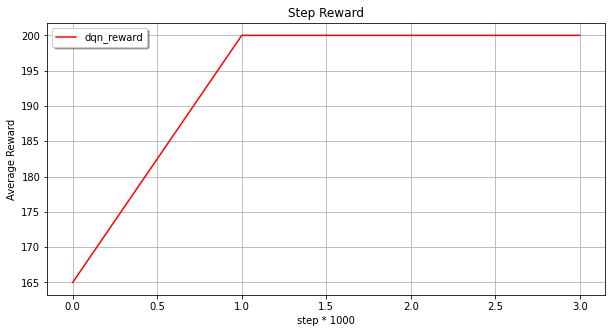

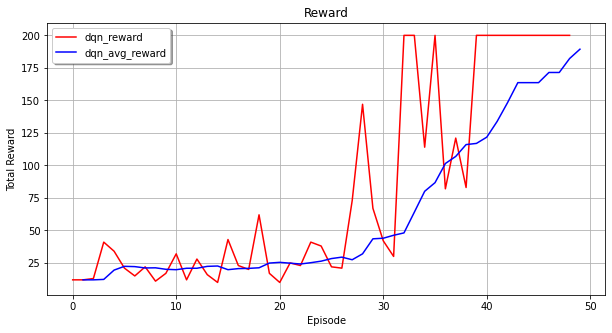

In [27]:
_step_plot(dqn_step)
_avg_plot(dqn_total)